Using TensorFlow backend.


帧数： 16000
声道数： 1
帧速率： 16000
实例的比特宽度，即每一帧的字节数 2


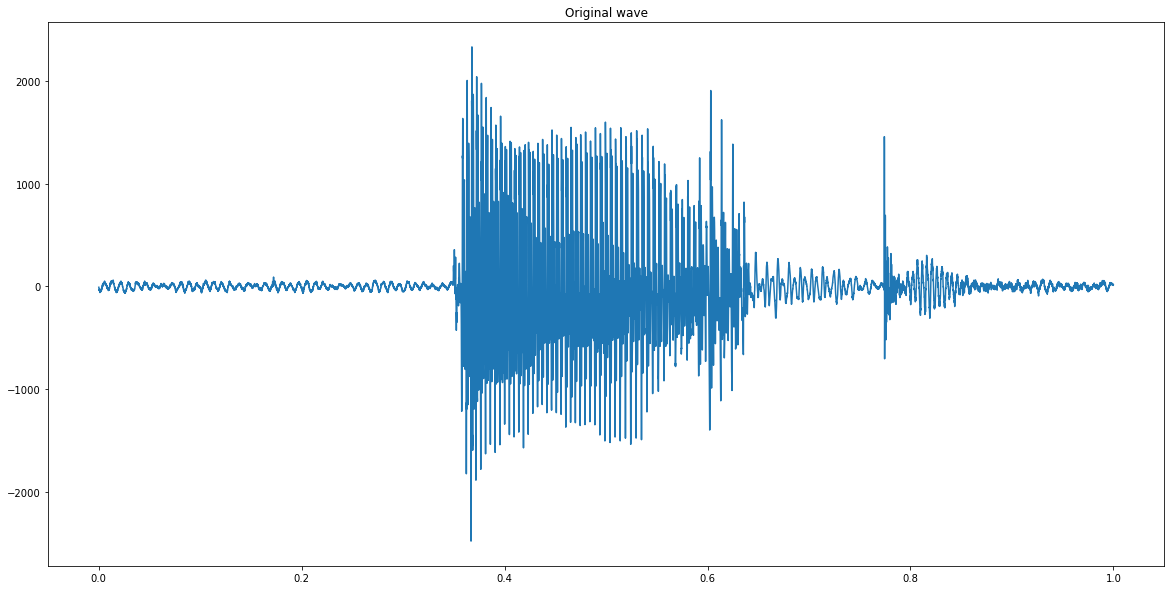

[ 0.51364299  0.51301812  0.51301812 ...,  0.51801708  0.51739221
  0.51864195]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000)             0         
_________________________________________________________________


C:\Users\86158\Anaconda3\lib\site-packages\ipykernel\__main__.py:104: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


dense_1 (Dense)              (None, 1600)              25601600  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               640400    
_________________________________________________________________
encoded (Dense)              (None, 200)               80200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
encoded_noise (GaussianNoise (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1600)              641600    
_________________________________________________________________
dense_5 (Dense)              (None, 16000)             25616000  
Total para

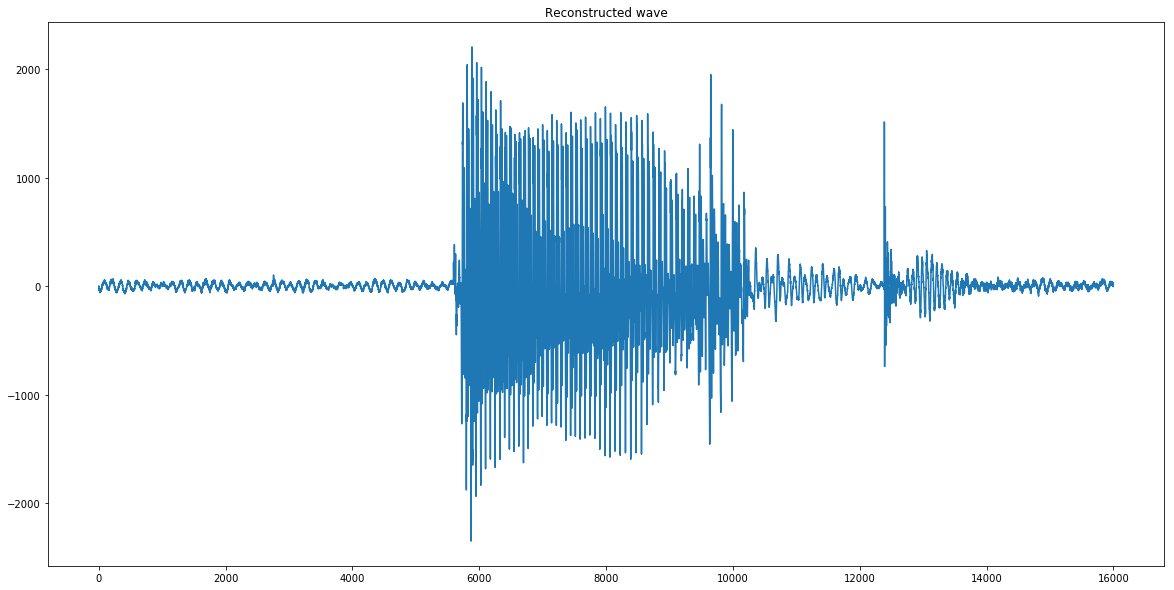

[0.0092299804, 0.0052335034, 0.0026070655, 0.0020258515, 0.0019898338, 0.0015267434, 0.00099998771, 0.00078517041, 0.00067168055, 0.00063037552, 0.00060389569, 0.00057719956, 0.00054796785, 0.00054810807, 0.00047066677, 0.00044826086, 0.00038183434, 0.00028855837, 0.00023942412, 0.00020596362, 0.00018184946, 0.00017680471, 0.00013829899, 0.0001294032, 0.00010825347, 0.00010963838, 8.6899607e-05, 8.9644447e-05, 8.1162703e-05, 6.612124e-05, 5.8060243e-05, 8.564577e-05, 6.0977069e-05, 5.0340273e-05, 6.0310729e-05, 4.1438201e-05, 3.6920392e-05, 3.450334e-05, 4.6676942e-05, 2.7478871e-05, 2.859513e-05, 5.8544796e-05, 3.9704486e-05, 1.8295914e-05, 1.5813424e-05, 1.4837802e-05, 1.3165431e-05, 3.0635587e-05, 7.9767597e-05, 1.3269219e-05, 1.2667098e-05, 1.0234443e-05, 1.4456376e-05, 8.9248406e-06, 7.9139318e-06, 6.7735587e-06, 2.7966418e-05, 8.5298689e-06, 4.9219518e-05, 5.1458837e-06, 7.0350875e-06, 2.5804129e-05, 1.7211631e-05, 1.7725692e-05, 1.465578e-05, 1.2084604e-05, 4.678026e-06, 3.71134

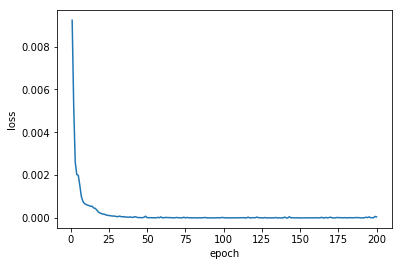

音频重建生成


In [1]:
import wave
import numpy as np
import math
import keras
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import GaussianNoise

filename = './Speech Command Dataset/bed/00f0204f_nohash_0.wav'
def read_wav_data(filename):
    '''
        读取一个wav文件，返回声音信号的时域谱矩阵和播放时间
    '''
    wav = wave.open(filename,"rb") # 打开一个wav格式的声音文件流
    num_frame = wav.getnframes() # 获取帧数
    print('帧数：',num_frame)
    num_channel=wav.getnchannels() # 获取声道数
    print('声道数：',num_channel)
    framerate=wav.getframerate() # 获取帧速率
    print('帧速率：',framerate)
    num_sample_width=wav.getsampwidth() # 获取实例的比特宽度，即每一帧的字节数
    print('实例的比特宽度，即每一帧的字节数',num_sample_width)
    str_data = wav.readframes(num_frame) # 读取全部的帧
    wav.close() # 关闭流
    wave_data = np.fromstring(str_data, dtype = np.short) # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T # 将矩阵转置
    return wave_data, framerate, num_frame, num_channel, num_sample_width, str_data
def wav_show(wave_data, fs): # 显示出来声音波形
    time = np.arange(0, len(wave_data)) * (1.0/fs)  # 计算声音的播放时间，单位为秒
    # 画声音波形
    plt.figure(figsize=(20,10))
    plt.plot(time, wave_data) 
    plt.title('Original wave')
    plt.show()  
def minmax_norm(x):
    x = (x-min(x))/(max(x)-min(x))
    print(x)
    return x
#--------------------------生成重建的wav
def Generate_Wav(filename, wave_data, framerate, num_frame, num_channel, num_sample_width):
    
    wave_data = wave_data.astype(np.short)
    #open a wav document
    f = wave.open(filename,"wb")
    #set wav params
    f.setnchannels(num_channel)
    f.setsampwidth(num_sample_width)
    f.setframerate(framerate)
    f.setnframes(num_frame)
    #turn the data to string
    f.writeframes(wave_data.tostring())
    f.close()
#-----------------------读入数据--------------------
    
wave_data, fs, num_frame, num_channel, num_sample_width, str_data = read_wav_data(filename)  
wav_show(wave_data[0],fs)
wave_data=wave_data[0]

#--------定义损失历史类，后面储存每次训练的loss值-----
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    
# -------------------data pre-processing------------------
# x_train = wave_data.astype('float32') + max(wave_data)   # minmax_normalized
xmax = max(wave_data)
xmin = min(wave_data)
x_train = minmax_norm(wave_data)
x_train = x_train.reshape((1,num_frame))
#print((x_train))

#---------------------编码----------------------

# x_train_noisy = x_train + np.random.normal(loc = 0, scale = 1, size = x_train.shape)
# 在原始数据中加入噪声，结果反而更好？？

x_train_noisy = x_train
# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
input_wave = Input(shape = (num_frame,))
encode1 = Dense(1600, activation = 'relu')(input_wave)
encode2 = Dense(400, activation = 'relu')(encode1)
encoded = Dense(200, activation = 'relu', name="encoded")(encode2)

# --------------------------加入噪声层------------------
# 对编码输出进行归一化，则能量为1
encoded = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(encoded)
std = 0.5011872336272722
encoded_noise = GaussianNoise(std, name='encoded_noise')(encoded)

#----------------------解码---------------------------
decode1 = Dense(400, activation = 'sigmoid')(encoded_noise)
decode3 = Dense(1600, activation = 'sigmoid')(decode1)
decoded = Dense(num_frame, activation = 'sigmoid')(decode3)

autoencoder = Model(input = input_wave, output = decoded)

autoencoder.compile(optimizer = 'adam', loss = 'mse')

history = LossHistory()

autoencoder.summary()

autoencoder.fit(x_train_noisy, x_train, epochs = 200, callbacks = [history])

#---------------- 输出中间层的结果----------------------

# #已有的model在load权重过后
# #取某一层的输出为输出新建为model，采用函数模型
# encoded_model = Model(inputs=autoencoder.input,
#                       output=autoencoder.get_layer('encoded').output)
# #以这个model的预测值作为输出
# encoded_output = encoded_model.predict(x_train_noisy)

# print('编码输出')
# print(np.var(encoded_output[0]))
# power = np.var(encoded_output[0])

print('信噪比: '+str(10*math.log10(1/(std*std))))

# #已有的model在load权重过后
# #取某一层的输出为输出新建为model，采用函数模型
# encoded_model = Model(inputs=autoencoder.input,
#                       output=autoencoder.get_layer('encoded_noise').output)
# #以这个model的预测值作为输出
# encoded_output = encoded_model.predict(x_train_noisy)

# print('编码输出')
# print(np.var(encoded_output[0]))
# power = np.var(encoded_output[0])

#---------------------译码结果----------------------------------

print('**************************最终结果****************************************')

decoded = autoencoder.predict(x_train_noisy)[0]
print(type(decoded))
decoded = decoded*(xmax-xmin)+xmin # denormalized
decoded = decoded.astype(np.int16)

mse = np.mean(pow(abs(wave_data-decoded),2))
print('mse: ',mse)

print(decoded)
print(type(decoded[0]))
print(wave_data)
print(type(wave_data[0]))
plt.figure(figsize=(20,10))
plt.title('Reconstructed wave')
plt.plot(decoded)
plt.show()


#----------------loss图---------------------
print(history.losses)
epoch = range(len(history.losses))
epoch = [i+1 for i in epoch]
plt.plot(epoch, history.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.show()



#-----------------------重建音频------------------

filename = './reconstruct_bed.wav'
Generate_Wav(filename, decoded, fs, num_frame, num_channel, num_sample_width )
print('音频重建生成')